<a href="https://colab.research.google.com/github/its-tayo/video_classification/blob/main/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video classification techniques

- Single-frame CNN
- Late fusion
- Early fusion
- CNN + LSTM
- Pose detection + LSTM
- Optical flow + CNN
- SlowFast networks
- 3D CNN/slow fusion


In [6]:
import os
import cv2
import math
# import pafy
import wandb
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
from wandb.keras import WandbCallback
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [7]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# !pip install wandb
# !wandb login
# !wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
# !unrar x UCF50.rar -inul -y

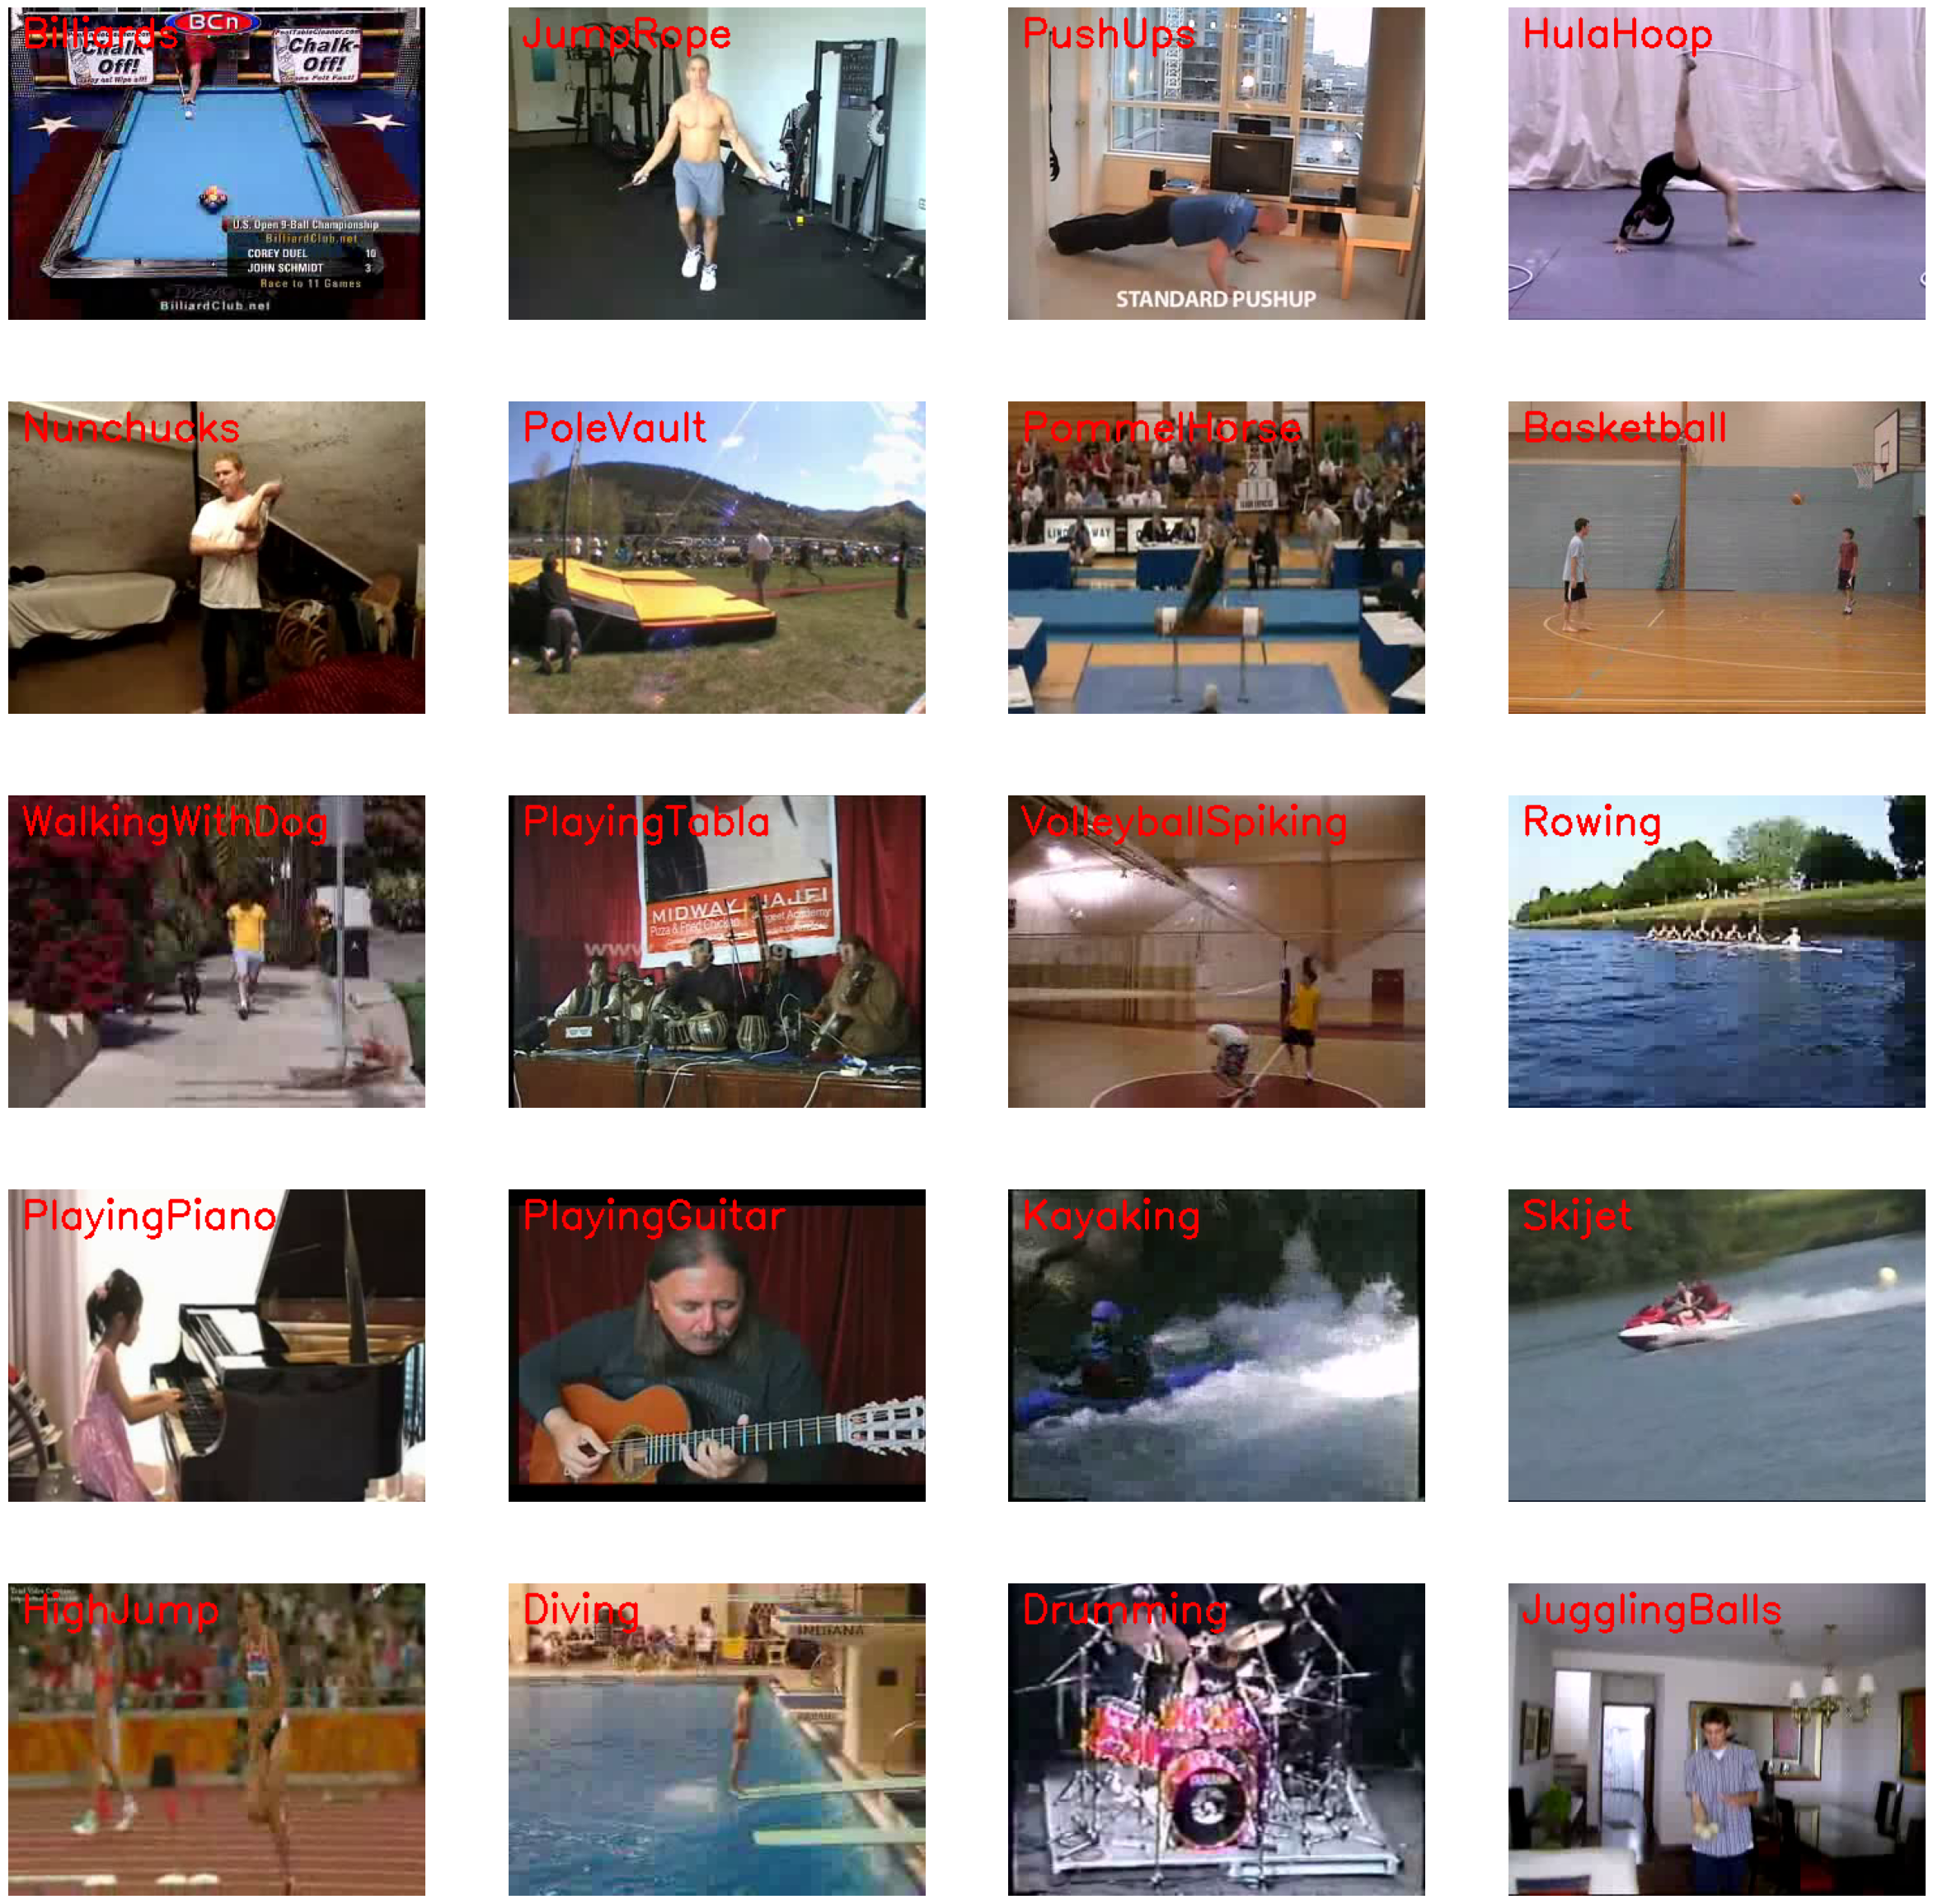

In [8]:
plt.figure(figsize = (30, 30))
all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
  selected_class_Name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  # Reading The First Frame of the Video File
  _, bgr_frame = video_reader.read()

  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Adding The Class Name Text on top of the Video Frame.
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

  plt.subplot(5, 4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

In [9]:
max_images_per_class = 8000
image_height, image_width = 64, 64

dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

model_output_size = len(classes_list)

In [10]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)

  while True:
    success, frame = video_reader.read()
    if not success:
      break

    resized_frame = cv2.resize(frame, (image_height, image_width))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()
  return frames_list


def create_dataset():
  labels = []
  features = []
  temp_features = []

  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting Data of Class: {class_name}')

    files_list = os.listdir(os.path.join(dataset_directory, class_name))

    for file_name in files_list:
      video_file_path = os.path.join(dataset_directory, class_name, file_name)

      frames = frames_extraction(video_file_path)
      temp_features.extend(frames)

    features.extend(random.sample(temp_features, max_images_per_class))
    labels.extend([class_index] * max_images_per_class)

    temp_features.clear()

  features = np.asarray(features)
  labels = np.array(labels)

  return features, labels

In [11]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)


In [14]:
wandb.init(project = 'video_classification_v1')
config = wandb.config

config.epochs = 50
config.batch_size = 4
config.dataset = "UCF50"
config.architecture = "CNN"
config.seed = seed_constant
config.activation = "softmax"

wandb: Currently logged in as: tayo. Use `wandb login --relogin` to force relogin


In [17]:
def create_model():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
  model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(model_output_size, activation = 'softmax'))

  # Printing the models summary
  model.summary()

  return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_2   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

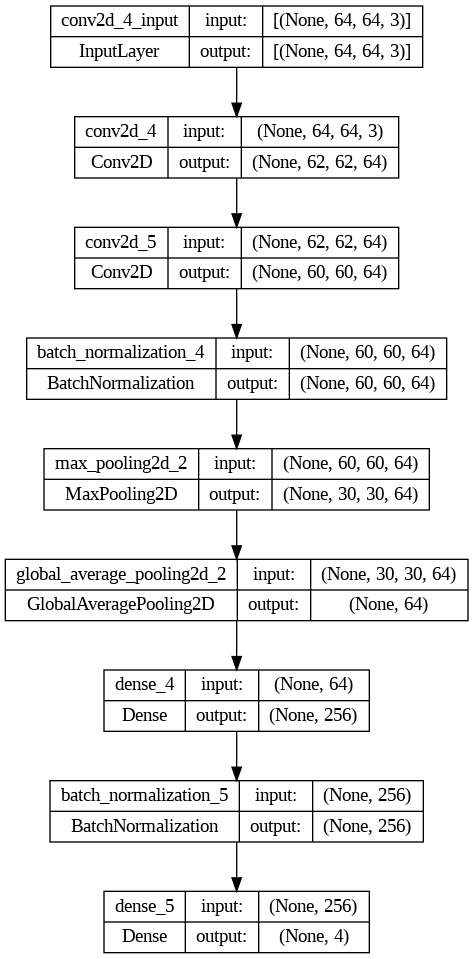

In [18]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(
    shuffle = True,
    y = labels_train,
    x = features_train,
    validation_split = 0.2,
    epochs = config.epochs,
    batch_size = config.batch_size,
    # callbacks = [early_stopping_callback]
    callbacks = [WandbCallback(data_type="image", validation_data=(features_test, labels_test), labels=classes_list), early_stopping_callback]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/50
2/2 [==============================] - 1s 61ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 736s 143ms/step - loss: 0.8651 - accuracy: 0.6488 - val_loss: 0.7282 - val_accuracy: 0.7312
Epoch 2/50
2/2 [==============================] - 0s 33ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 728s 142ms/step - loss: 0.5111 - accuracy: 0.8114 - val_loss: 0.5107 - val_accuracy: 0.7928
Epoch 3/50
  55/5120 [..............................] - ETA: 17:46 - loss: 0.4541 - accuracy: 0.8409

wandb: Network error resolved after 0:00:01.156600, resuming normal operation.


2/2 [==============================] - 0s 31ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 751s 147ms/step - loss: 0.3829 - accuracy: 0.8631 - val_loss: 0.2611 - val_accuracy: 0.9139
Epoch 4/50
  57/5120 [..............................] - ETA: 16:02 - loss: 0.3486 - accuracy: 0.8816

wandb: Network error resolved after 0:00:01.098957, resuming normal operation.


2/2 [==============================] - 0s 31ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 751s 147ms/step - loss: 0.3164 - accuracy: 0.8902 - val_loss: 0.2086 - val_accuracy: 0.9377
Epoch 5/50
  46/5120 [..............................] - ETA: 18:47 - loss: 0.3146 - accuracy: 0.8804

wandb: Network error resolved after 0:00:01.224878, resuming normal operation.


5120/5120 [==============================] - 727s 142ms/step - loss: 0.2802 - accuracy: 0.9058 - val_loss: 1.3378 - val_accuracy: 0.7383
Epoch 6/50
  14/5120 [..............................] - ETA: 18:08 - loss: 0.1195 - accuracy: 0.9643

wandb: Network error resolved after 0:00:01.064754, resuming normal operation.


2/2 [==============================] - 0s 36ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 718s 140ms/step - loss: 0.2542 - accuracy: 0.9123 - val_loss: 0.1141 - val_accuracy: 0.9729
Epoch 7/50
2/2 [==============================] - 0s 36ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 723s 141ms/step - loss: 0.2422 - accuracy: 0.9191 - val_loss: 0.1012 - val_accuracy: 0.9695
Epoch 8/50
2/2 [==============================] - 0s 33ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 710s 139ms/step - loss: 0.2066 - accuracy: 0.9319 - val_loss: 0.0763 - val_accuracy: 0.9785
Epoch 9/50
5120/5120 [==============================] - 710s 139ms/step - loss: 0.2116 - accuracy: 0.9336 - val_loss: 0.1675 - val_accuracy: 0.9494
Epoch 10/50
5120/5120 [==============================] - 718s 140ms/step - loss: 0.1907 - accuracy: 0.9379 - val_loss: 0.1579 - val_accuracy: 0.9479
Epoch 11/50
5120/5120 [==============================] - 711s 139ms/step - loss: 0.1849 - accuracy: 0.9408 - val_loss: 0.3208 - val_accuracy: 0.9396
Epoch 12/50
5120/5120 [==============================] - 715s 140ms/step - loss: 0.1829 - accuracy: 0.9423 - val_loss: 0.1499 - val_accuracy: 0.9756
Epoch 13/50
2/2 [==============================] - 0s 32ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 712s 139ms/step - loss: 0.1718 - accuracy: 0.9439 - val_loss: 0.0692 - val_accuracy: 0.9820
Epoch 14/50
2/2 [==============================] - 0s 62ms/step


wandb: Adding directory to artifact (/content/wandb/run-20230907_060510-lpgfk99v/files/model-best)... Done. 0.0s


5120/5120 [==============================] - 703s 137ms/step - loss: 0.1533 - accuracy: 0.9495 - val_loss: 0.0480 - val_accuracy: 0.9824
Epoch 15/50
5120/5120 [==============================] - 701s 137ms/step - loss: 0.1644 - accuracy: 0.9491 - val_loss: 0.1704 - val_accuracy: 0.9715
Epoch 16/50
5120/5120 [==============================] - 708s 138ms/step - loss: 0.1543 - accuracy: 0.9508 - val_loss: 0.2165 - val_accuracy: 0.9264
Epoch 17/50
5120/5120 [==============================] - 716s 140ms/step - loss: 0.1486 - accuracy: 0.9535 - val_loss: 0.1248 - val_accuracy: 0.9814
Epoch 18/50
5120/5120 [==============================] - 730s 143ms/step - loss: 0.1403 - accuracy: 0.9547 - val_loss: 0.0619 - val_accuracy: 0.9865
Epoch 19/50
5120/5120 [==============================] - 729s 142ms/step - loss: 0.1411 - accuracy: 0.9567 - val_loss: 0.0775 - val_accuracy: 0.9785
Epoch 20/50
5120/5120 [==============================] - 735s 143ms/step - loss: 0.1370 - accuracy: 0.9570 - val_loss:

In [20]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 44s 218ms/step - loss: 0.0607 - accuracy: 0.9831


In [22]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

In [23]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))

  plt.legend()

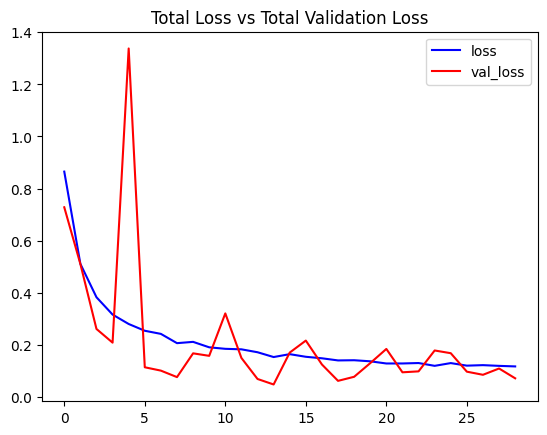

In [24]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

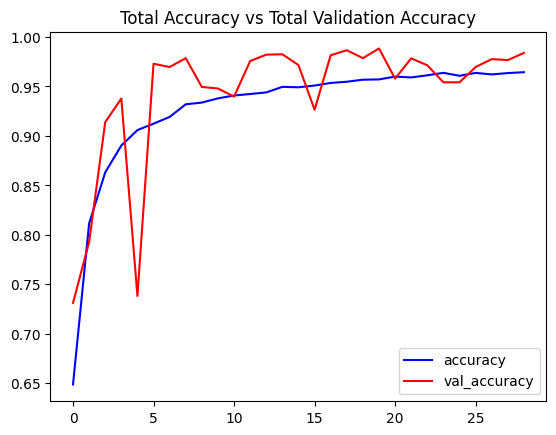

In [25]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')